In [ ]:
%pip install tensorflow opencv-python scikit-learn numpy matplotlib

## Dataset upload and preparation




In [25]:
# Instructions for uploading the dataset:
# 1. In the left sidebar of Google Colab, click on the "Files" tab (folder icon).
# 2. Click on the "Upload to session storage" icon (up arrow icon).
# 3. Select the "avengers-faces-dataset.zip" file from your local machine and upload it.
# The file will be available in the Colab environment's temporary storage.

import zipfile
import os

zip_file_name = "avengers-faces-dataset.zip"
extracted_folder_name = "avengers-faces-dataset"

if os.path.exists(zip_file_name):
    try:
        with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
            zip_ref.extractall(extracted_folder_name)
        print(f"Successfully extracted {zip_file_name} to {extracted_folder_name}")

        if os.path.exists(extracted_folder_name):
            print(f"\nContents of the extracted directory '{extracted_folder_name}':")
            for item in os.listdir(extracted_folder_name):
                print(item)
        else:
            print(f"Error: The extracted directory '{extracted_folder_name}' was not found.")
    except zipfile.BadZipFile:
        print(f"Error: The file '{zip_file_name}' is not a valid zip file or is corrupted.")
        print("Please ensure you have uploaded the correct zip file.")
else:
    print(f"Error: The file '{zip_file_name}' was not found. Please upload the dataset first.")

Successfully extracted avengers-faces-dataset.zip to avengers-faces-dataset

Contents of the extracted directory 'avengers-faces-dataset':
avengers-faces-dataset
val
test
train


## Face detection model




In [26]:
import cv2
import numpy as np

# 1. Explain that a pre-trained face detection model is a model that has already been trained on a large dataset of images to identify the locations of faces.
print("A pre-trained face detection model is a model that has already been trained on a large dataset of images to identify the locations of faces.")

# 2. Explain that using a pre-trained model saves time and computational resources compared to training one from scratch.
print("Using a pre-trained model saves time and computational resources compared to training one from scratch.")

# 3. Explain that OpenCV provides pre-trained Haar cascades for face detection, which are simple yet effective for many use cases.
print("OpenCV provides pre-trained Haar cascades for face detection, which are simple yet effective for many use cases.")

# 4. Provide code to load the pre-trained Haar cascade classifier for face detection from OpenCV.
# We will use the default Haar cascade for frontal faces provided by OpenCV
face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(face_cascade_path)

if face_cascade.empty():
    print(f"Error loading cascade classifier from {face_cascade_path}")
else:
    print("Haar cascade classifier loaded successfully.")

# 5. Provide a function that takes an image (as a NumPy array) as input and returns the bounding box coordinates of the detected faces using the loaded Haar cascade classifier.
def detect_faces(image_array):
    """
    Detects faces in an image using the loaded Haar cascade classifier.

    Args:
        image_array: A NumPy array representing the image (e.g., from cv2.imread).

    Returns:
        A list of bounding box coordinates (x, y, w, h) for each detected face.
        Returns an empty list if no faces are detected or if the cascade classifier
        was not loaded successfully.
    """
    if face_cascade.empty():
        print("Face cascade classifier not loaded. Cannot perform detection.")
        return []

    # Convert the image to grayscale, which is required for Haar cascades
    gray_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale image
    # The detectMultiScale function detects objects of different sizes in the input image.
    # The detected objects are returned as a list of rectangles.
    # 1.1 is the scaleFactor: Specifies how much the image size is reduced at each image scale.
    # 4 is the minNeighbors: Specifies how many neighbors each candidate rectangle should have to retain it.
    # minSize: Minimum possible object size. Objects smaller than that are ignored.
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=4, minSize=(30, 30))

    return faces

print("\n'detect_faces' function is ready to use.")


A pre-trained face detection model is a model that has already been trained on a large dataset of images to identify the locations of faces.
Using a pre-trained model saves time and computational resources compared to training one from scratch.
OpenCV provides pre-trained Haar cascades for face detection, which are simple yet effective for many use cases.
Haar cascade classifier loaded successfully.

'detect_faces' function is ready to use.


## Face recognition model training


In [28]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, BatchNormalization, Activation, Conv2D, add, Input, DepthwiseConv2D, GlobalAveragePooling2D, Reshape, Dense

# Assuming the 'avengers-faces-dataset' is extracted in the current directory
dataset_path = 'avengers-faces-dataset'

# Define face alignment parameters
IMG_SIZE = 160 # Standard size for face recognition models

# Load a pre-trained face recognition model (e.g., MobileNetV2 as a base for embeddings)
# We will use a simplified MobileNetV2 architecture as a feature extractor.
# This is a common approach when training a classifier on top of learned embeddings.

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def correct_pad(inputs, kernel_size):
    img_dim = 2
    input_size = inputs.get_shape().as_list()[img_dim]
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    adjust = (kernel_size[0] - 1, kernel_size[0] - 1)
    nofold = (kernel_size[0] - 1) // 2
    left, right = adjust
    return [[0, 0], [left // 2, right - nofold], [left // 2, right - nofold], [0, 0]]

def expanded_conv_block(inputs, expanded_channels, reduced_channels, strides, block_id):
    channel_axis = -1

    prefix = f'expanded_conv_{block_id}'

    x = Conv2D(expanded_channels, kernel_size=1, use_bias=False, padding='same',
               name=prefix + '_expand')(inputs)
    x = BatchNormalization(axis=channel_axis, name=prefix + '_expand_BN')(x)
    x = Activation(tf.nn.relu6, name=prefix + '_expand_relu')(x)

    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False,
                        name=prefix + '_depthwise')(x)
    x = BatchNormalization(axis=channel_axis, name=prefix + '_depthwise_BN')(x)
    x = Activation(tf.nn.relu6, name=prefix + '_depthwise_relu')(x)

    x = Conv2D(reduced_channels, kernel_size=1, use_bias=False, padding='same',
               name=prefix + '_project')(x)
    x = BatchNormalization(axis=channel_axis, name=prefix + '_project_BN')(x)

    if strides == 1 and inputs.shape[-1] == reduced_channels:
        x = add([x, inputs])

    return x

def MobileNetV2(input_shape=None, alpha=1.0, include_top=True, weights='imagenet', pooling=None):
    input_shape = input_shape or (IMG_SIZE, IMG_SIZE, 3)
    img_input = Input(shape=input_shape)

    channel_axis = -1

    first_block_filters = _make_divisible(32 * alpha, 8)
    x = Conv2D(first_block_filters, kernel_size=3, strides=(2, 2), padding='same',
               use_bias=False, name='Conv1')(img_input)
    x = BatchNormalization(axis=channel_axis, name='Conv1_BN')(x)
    x = Activation(tf.nn.relu6, name='Conv1_relu')(x)

    x = expanded_conv_block(x, 16, 16, strides=1, block_id=0)

    x = expanded_conv_block(x, _make_divisible(96 * alpha, 8), _make_divisible(24 * alpha, 8), strides=2, block_id=1)
    x = expanded_conv_block(x, _make_divisible(144 * alpha, 8), _make_divisible(24 * alpha, 8), strides=1, block_id=2)

    x = expanded_conv_block(x, _make_divisible(144 * alpha, 8), _make_divisible(32 * alpha, 8), strides=2, block_id=3)
    x = expanded_conv_block(x, _make_divisible(192 * alpha, 8), _make_divisible(32 * alpha, 8), strides=1, block_id=4)
    x = expanded_conv_block(x, _make_divisible(192 * alpha, 8), _make_divisible(32 * alpha, 8), strides=1, block_id=5)

    x = expanded_conv_block(x, _make_divisible(192 * alpha, 8), _make_divisible(64 * alpha, 8), strides=2, block_id=6)
    x = expanded_conv_block(x, _make_divisible(384 * alpha, 8), _make_divisible(64 * alpha, 8), strides=1, block_id=7)
    x = expanded_conv_block(x, _make_divisible(384 * alpha, 8), _make_divisible(64 * alpha, 8), strides=1, block_id=8)
    x = expanded_conv_block(x, _make_divisible(384 * alpha, 8), _make_divisible(64 * alpha, 8), strides=1, block_id=9)

    x = expanded_conv_block(x, _make_divisible(384 * alpha, 8), _make_divisible(96 * alpha, 8), strides=1, block_id=10)
    x = expanded_conv_block(x, _make_divisible(576 * alpha, 8), _make_divisible(96 * alpha, 8), strides=1, block_id=11)
    x = expanded_conv_block(x, _make_divisible(576 * alpha, 8), _make_divisible(96 * alpha, 8), strides=1, block_id=12)

    x = expanded_conv_block(x, _make_divisible(576 * alpha, 8), _make_divisible(160 * alpha, 8), strides=2, block_id=13)
    x = expanded_conv_block(x, _make_divisible(960 * alpha, 8), _make_divisible(160 * alpha, 8), strides=1, block_id=14)
    x = expanded_conv_block(x, _make_divisible(960 * alpha, 8), _make_divisible(160 * alpha, 8), strides=1, block_id=15)

    x = expanded_conv_block(x, _make_divisible(960 * alpha, 8), _make_divisible(320 * alpha, 8), strides=1, block_id=16)

    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    x = Conv2D(last_block_filters, kernel_size=1, use_bias=False,
               name='Conv_1')(x)
    x = BatchNormalization(axis=channel_axis, name='Conv_1_BN')(x)
    x = Activation(tf.nn.relu6, name='Conv_1_relu')(x)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        # Add a dense layer for embeddings, outputting a fixed size vector (e.g., 128 or 512)
        # This is where we diverge from standard classification to embedding generation
        x = Dense(128, name='embeddings')(x) # Output 128-dimensional embeddings
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Create the model
    model = Model(inputs=img_input, outputs=x, name='mobilenetv2_face_embeddings')

    # Load pre-trained weights (optional, but helps with initial feature extraction)
    # For simplicity and to avoid large file downloads, we'll skip loading ImageNet weights directly
    # and assume the architecture is suitable for learning face features with appropriate training.
    # In a real-world scenario, you might load weights from a model trained on a large face dataset.

    return model

# Load the embedding model
embedding_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=True)
embedding_model.summary()

# Prepare lists to store embeddings and labels
embeddings = []
labels = []
label_map = {} # Map character name to integer label
next_label = 0

print(f"Processing dataset from: {dataset_path}")

# Iterate through the dataset directory
for character_name in os.listdir(dataset_path):
    character_dir = os.path.join(dataset_path, character_name)

    if os.path.isdir(character_dir):
        print(f"Processing character: {character_name}")
        if character_name not in label_map:
            label_map[character_name] = next_label
            next_label += 1

        for image_name in os.listdir(character_dir):
            image_path = os.path.join(character_dir, image_name)

            if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Read the image
                image = cv2.imread(image_path)

                if image is not None:
                    # Detect faces in the image
                    detected_faces = detect_faces(image) # Assuming detect_faces is defined in a previous cell

                    if len(detected_faces) > 0:
                        # For simplicity, process only the first detected face
                        # In a real system, you might handle multiple faces per image differently
                        (x, y, w, h) = detected_faces[0]

                        # Extract the face region
                        face_img = image[y:y+h, x:x+w]

                        # Align/Resize the face to the standard size
                        aligned_face = cv2.resize(face_img, (IMG_SIZE, IMG_SIZE))

                        # Preprocess the image for the model (normalize pixel values)
                        # Assuming the MobileNetV2 expects pixel values in [-1, 1] or [0, 1]
                        # Based on common MobileNetV2 preprocessing, we'll normalize to [-1, 1]
                        aligned_face = aligned_face.astype('float32') / 127.5 - 1.0
                        aligned_face = np.expand_dims(aligned_face, axis=0) # Add batch dimension

                        # Generate embeddings for the aligned face
                        face_embedding = embedding_model.predict(aligned_face)

                        # Store the embedding and corresponding label
                        embeddings.append(face_embedding.flatten()) # Flatten the embedding vector
                        labels.append(label_map[character_name])
                    else:
                        print(f"No faces detected in {image_path}")
                else:
                    print(f"Could not read image: {image_path}")

# Convert lists to NumPy arrays
embeddings = np.array(embeddings)
labels = np.array(labels)

print(f"\nFinished processing dataset.")
print(f"Total embeddings generated: {len(embeddings)}")
print(f"Total labels collected: {len(labels)}")
print(f"Number of unique characters (classes): {len(label_map)}")
print("Label map:", label_map)

# Now you have 'embeddings' (the features) and 'labels' (the target classes)
# for training a classification model on top of the embeddings.
# This completes the dataset preparation for training.

Model: "mobilenetv2_face_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_BN            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu          │ (None, 80, 80,    │          0 │ Conv1_BN[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_0_ex… │ (None, 80, 80,    │        512 │ Conv1_relu[0][0]  │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_0_ex… │ (None, 80, 80,    │         64 │ expanded_conv_0_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_0_ex… │ (None, 80, 80,    │          0 │ expanded_conv_0_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_0_de… │ (None, 80, 80,    │        144 │ expanded_conv_0_… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_0_de… │ (None, 80, 80,    │         64 │ expanded_conv_0_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_0_de… │ (None, 80, 80,    │          0 │ expanded_conv_0_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_0_pr… │ (None, 80, 80,    │        256 │ expanded_conv_0_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_0_pr… │ (None, 80, 80,    │         64 │ expanded_conv_0_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 80, 80,    │      1,536 │ expanded_conv_0_… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 80, 80,    │        384 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 80, 80,    │          0 │ expanded_conv_1_… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 40, 40,    │        864 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 40, 40,    │        384 │ expanded_conv_1_

 Total params: 2,422,064 (9.24 MB)

 Trainable params: 2,387,952 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

Processing dataset from: dataset
Processing character: avengers-faces-dataset

Finished processing dataset.
Total embeddings generated: 0
Total labels collected: 0
Number of unique characters (classes): 1
Label map: {'avengers-faces-dataset': 0}


In [40]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, BatchNormalization, Activation, Conv2D, add, Input, DepthwiseConv2D, GlobalAveragePooling2D, Reshape, Dense

# Assuming the 'avengers-faces-dataset' is extracted in the current directory
base_dataset_path = 'avengers-faces-dataset'

# Define face alignment parameters
IMG_SIZE = 160 # Standard size for face recognition models

# Load a pre-trained face recognition model (e.g., MobileNetV2 as a base for embeddings)
# We will use a simplified MobileNetV2 architecture as a feature extractor.
# This is a common approach when training a classifier on top of learned embeddings.

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def correct_pad(inputs, kernel_size):
    img_dim = 2
    input_size = inputs.get_shape().as_list()[img_dim]
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    adjust = (kernel_size[0] - 1, kernel_size[0] - 1)
    nofold = (kernel_size[0] - 1) // 2
    left, right = adjust
    return [[0, 0], [left // 2, right - nofold], [left // 2, right - nofold], [0, 0]]

def expanded_conv_block(inputs, expanded_channels, reduced_channels, strides, block_id):
    channel_axis = -1

    prefix = f'expanded_conv_{block_id}'

    x = Conv2D(expanded_channels, kernel_size=1, use_bias=False, padding='same',
               name=prefix + '_expand')(inputs)
    x = BatchNormalization(axis=channel_axis, name=prefix + '_expand_BN')(x)
    x = Activation(tf.nn.relu6, name=prefix + '_expand_relu')(x)

    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False,
                        name=prefix + '_depthwise')(x)
    x = BatchNormalization(axis=channel_axis, name=prefix + '_depthwise_BN')(x)
    x = Activation(tf.nn.relu6, name=prefix + '_depthwise_relu')(x)

    x = Conv2D(reduced_channels, kernel_size=1, use_bias=False, padding='same',
               name=prefix + '_project')(x)
    x = BatchNormalization(axis=channel_axis, name=prefix + '_project_BN')(x)

    if strides == 1 and inputs.shape[-1] == reduced_channels:
        x = add([x, inputs])

    return x

def MobileNetV2(input_shape=None, alpha=1.0, include_top=True, weights='imagenet', pooling=None):
    input_shape = input_shape or (IMG_SIZE, IMG_SIZE, 3)
    img_input = Input(shape=input_shape)

    channel_axis = -1

    first_block_filters = _make_divisible(32 * alpha, 8)
    x = Conv2D(first_block_filters, kernel_size=3, strides=(2, 2), padding='same',
               use_bias=False, name='Conv1')(img_input)
    x = BatchNormalization(axis=channel_axis, name='Conv1_BN')(x)
    x = Activation(tf.nn.relu6, name='Conv1_relu')(x)

    x = expanded_conv_block(x, 16, 16, strides=1, block_id=0)

    x = expanded_conv_block(x, _make_divisible(96 * alpha, 8), _make_divisible(24 * alpha, 8), strides=2, block_id=1)
    x = expanded_conv_block(x, _make_divisible(144 * alpha, 8), _make_divisible(24 * alpha, 8), strides=1, block_id=2)

    x = expanded_conv_block(x, _make_divisible(144 * alpha, 8), _make_divisible(32 * alpha, 8), strides=2, block_id=3)
    x = expanded_conv_block(x, _make_divisible(192 * alpha, 8), _make_divisible(32 * alpha, 8), strides=1, block_id=4)
    x = expanded_conv_block(x, _make_divisible(192 * alpha, 8), _make_divisible(32 * alpha, 8), strides=1, block_id=5)

    x = expanded_conv_block(x, _make_divisible(192 * alpha, 8), _make_divisible(64 * alpha, 8), strides=2, block_id=6)
    x = expanded_conv_block(x, _make_divisible(384 * alpha, 8), _make_divisible(64 * alpha, 8), strides=1, block_id=7)
    x = expanded_conv_block(x, _make_divisible(384 * alpha, 8), _make_divisible(64 * alpha, 8), strides=1, block_id=8)
    x = expanded_conv_block(x, _make_divisible(384 * alpha, 8), _make_divisible(64 * alpha, 8), strides=1, block_id=9)

    x = expanded_conv_block(x, _make_divisible(384 * alpha, 8), _make_divisible(96 * alpha, 8), strides=1, block_id=10)
    x = expanded_conv_block(x, _make_divisible(576 * alpha, 8), _make_divisible(96 * alpha, 8), strides=1, block_id=11)
    x = expanded_conv_block(x, _make_divisible(576 * alpha, 8), _make_divisible(96 * alpha, 8), strides=1, block_id=12)

    x = expanded_conv_block(x, _make_divisible(576 * alpha, 8), _make_divisible(160 * alpha, 8), strides=2, block_id=13)
    x = expanded_conv_block(x, _make_divisible(960 * alpha, 8), _make_divisible(160 * alpha, 8), strides=1, block_id=14)
    x = expanded_conv_block(x, _make_divisible(960 * alpha, 8), _make_divisible(160 * alpha, 8), strides=1, block_id=15)

    x = expanded_conv_block(x, _make_divisible(960 * alpha, 8), _make_divisible(320 * alpha, 8), strides=1, block_id=16)

    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    x = Conv2D(last_block_filters, kernel_size=1, use_bias=False,
               name='Conv_1')(x)
    x = BatchNormalization(axis=channel_axis, name='Conv_1_BN')(x)
    x = Activation(tf.nn.relu6, name='Conv_1_relu')(x)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        # Add a dense layer for embeddings, outputting a fixed size vector (e.g., 128 or 512)
        # This is where we diverge from standard classification to embedding generation
        x = Dense(128, name='embeddings')(x) # Output 128-dimensional embeddings
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Create the model
    model = Model(inputs=img_input, outputs=x, name='mobilenetv2_face_embeddings')

    # Load pre-trained weights (optional, but helps with initial feature extraction)
    # For simplicity and to avoid large file downloads, we'll skip loading ImageNet weights directly
    # and assume the architecture is suitable for learning face features with appropriate training.
    # In a real-world scenario, you might load weights from a model trained on a large face dataset.

    return model

# Load the embedding model
embedding_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=True)
# embedding_model.summary() # Removed summary to avoid repeated output

# Prepare lists to store embeddings and labels
embeddings = []
labels = []
label_map = {} # Map character name to integer label
next_label = 0

print(f"Processing dataset from: {base_dataset_path}")

# Add a check for the dataset directory
if not os.path.exists(base_dataset_path):
    print(f"Error: Dataset directory '{base_dataset_path}' not found.")
    print("Please upload the 'avengers-faces-dataset.zip' file and run the dataset extraction step first.")
else:
    # Iterate through train, test, and val directories
    for data_split in ['train', 'test', 'val']:
        split_path = os.path.join(base_dataset_path, data_split)
        if os.path.isdir(split_path):
            print(f"Processing data split: {data_split}")
            # Iterate through character folders within the data split
            for character_name in os.listdir(split_path):
                character_dir = os.path.join(split_path, character_name)

                if os.path.isdir(character_dir):
                    print(f"  Processing character: {character_name}")
                    if character_name not in label_map:
                        label_map[character_name] = next_label
                        next_label += 1

                    for image_name in os.listdir(character_dir):
                        image_path = os.path.join(character_dir, image_name)

                        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                            # Read the image
                            image = cv2.imread(image_path)

                            if image is not None:
                                # Detect faces in the image
                                # Assuming detect_faces is defined in a previous cell
                                detected_faces = detect_faces(image)

                                if len(detected_faces) > 0:
                                    # For simplicity, process only the first detected face
                                    # In a real system, you might handle multiple faces per image differently
                                    (x, y, w, h) = detected_faces[0]

                                    # Extract the face region
                                    face_img = image[y:y+h, x:x+w]

                                    # Align/Resize the face to the standard size
                                    aligned_face = cv2.resize(face_img, (IMG_SIZE, IMG_SIZE))

                                    # Preprocess the image for the model (normalize pixel values)
                                    # Assuming the MobileNetV2 expects pixel values in [-1, 1] or [0, 1]
                                    # Based on common MobileNetV2 preprocessing, we'll normalize to [-1, 1]
                                    aligned_face = aligned_face.astype('float32') / 127.5 - 1.0
                                    aligned_face = np.expand_dims(aligned_face, axis=0) # Add batch dimension

                                    # Generate embeddings for the aligned face
                                    face_embedding = embedding_model.predict(aligned_face)

                                    # Store the embedding and corresponding label
                                    embeddings.append(face_embedding.flatten()) # Flatten the embedding vector
                                    labels.append(label_map[character_name])
                                else:
                                    print(f"  No faces detected in {image_path}")
                            else:
                                print(f"  Could not read image: {image_path}")
        else:
            print(f"Warning: Data split directory '{split_path}' not found.")


    # Convert lists to NumPy arrays
    embeddings = np.array(embeddings)
    labels = np.array(labels)

    print(f"\nFinished processing dataset.")
    print(f"Total embeddings generated: {len(embeddings)}")
    print(f"Total labels collected: {len(labels)}")
    print(f"Number of unique characters (classes): {len(label_map)}")
    print("Label map:", label_map)


Processing dataset from: avengers-faces-dataset
Processing data split: train
  Processing character: mark_ruffalo
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

## Face recognition model training

In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Check if embeddings and labels were successfully generated
if len(embeddings) > 0 and len(labels) > 0:
    # Split the data into training and testing sets
    # Using a small test size as the dataset is likely small
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

    print(f"\nTraining SVM classifier...")
    # Train a Support Vector Machine (SVM) classifier on the embeddings
    # A linear SVM is often a good starting point for classification on embeddings
    classifier = SVC(kernel='linear', probability=True) # probability=True allows using predict_proba later
    classifier.fit(X_train, y_train)

    print(f"SVM classifier trained.")

    # Evaluate the classifier (optional, but good practice)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classifier accuracy on test set: {accuracy:.4f}")

    # Store the trained classifier and label map for later use
    # In a real application, you would save these to disk
    # For this notebook, we'll keep them in memory
    print("\nClassification model trained and ready for prediction.")
else:
    print("\nSkipping classifier training: No embeddings or labels were generated.")



Training SVM classifier...
SVM classifier trained.
Classifier accuracy on test set: 0.1111

Classification model trained and ready for prediction.


## Face recognition inference

In [42]:
import cv2
import numpy as np
import tensorflow as tf
from scipy.spatial.distance import euclidean

def recognize_faces_in_image(image_array):
    """
    Detects and recognizes faces in an input image.

    Args:
        image_array: A NumPy array representing the input image (e.g., from cv2.imread).

    Returns:
        A copy of the input image with drawn bounding boxes and recognized names,
        or None if required models/data are not available.
    """
    # 7. Add a check at the beginning of the function or before calling it to ensure that
    required_vars = ['embeddings', 'labels', 'label_map', 'embedding_model']
    for var_name in required_vars:
        if var_name not in globals():
            print(f"Error: Required variable '{var_name}' is not available.")
            print("Please ensure the dataset processing and embedding generation steps were successful.")
            return None

    if len(embeddings) == 0 or len(labels) == 0:
         print("Error: Embeddings or labels are empty. Cannot perform recognition.")
         print("Please ensure the dataset processing and embedding generation steps were successful and found faces.")
         return None


    # Make a copy of the image to draw on
    output_image = image_array.copy()

    # 2. Inside the function, call the detect_faces function (defined previously)
    # to get the bounding boxes of faces in the input image.
    detected_faces = detect_faces(image_array)

    # 3. Initialize an empty list to store the results
    recognition_results = []

    # 4. Iterate through each detected face bounding box:
    for (x, y, w, h) in detected_faces:
        # Extract the face region
        face_img = image_array[y:y+h, x:x+w]

        # Resize and preprocess the extracted face image
        aligned_face = cv2.resize(face_img, (IMG_SIZE, IMG_SIZE))

        # Preprocess the image for the model (normalize pixel values)
        aligned_face = aligned_face.astype('float32') / 127.5 - 1.0
        aligned_face = np.expand_dims(aligned_face, axis=0) # Add batch dimension

        # Use the embedding_model.predict() method to get the embedding vector
        face_embedding = embedding_model.predict(aligned_face).flatten() # Flatten for distance calculation

        # Compare this face embedding with the embeddings array
        # Calculate Euclidean distance between the current face embedding and all training embeddings.
        distances = [euclidean(face_embedding, known_embedding) for known_embedding in embeddings]

        # Find the index of the training embedding with the minimum distance.
        min_distance_index = np.argmin(distances)
        min_distance = distances[min_distance_index]

        distance_threshold = 1.0

        if min_distance < distance_threshold:
            # Use this index to get the corresponding label from the labels array.
            recognized_label_id = labels[min_distance_index]

            # Convert the label (integer) back to the character name using the label_map dictionary.
            # Find the key (name) for the value (label_id) in label_map
            recognized_name = "Unknown"
            for name, label_id in label_map.items():
                if label_id == recognized_label_id:
                    recognized_name = name
                    break
        else:
            recognized_name = "Unknown"


        # Store the bounding box coordinates and the recognized character name
        recognition_results.append({
            'bounding_box': (x, y, w, h),
            'name': recognized_name,
            'distance': min_distance # Optional: store distance for debugging/analysis
        })

        # 5. After processing all detected faces, iterate through the results list
        # and draw the bounding boxes and recognized names on a copy of the input image.
        color = (0, 255, 0) # Green color for bounding box
        thickness = 2
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1

        # Draw bounding box
        cv2.rectangle(output_image, (x, y), (x+w, y+h), color, thickness)

        # Draw label
        # Position the text slightly above the bounding box
        label_position = (x, y - 10)
        cv2.putText(output_image, recognized_name, label_position, font, font_scale, color, font_thickness, cv2.LINE_AA)

    print(f"Processed {len(detected_faces)} faces. Recognition results: {recognition_results}")

    # 6. Return the image with the drawn bounding boxes and labels
    return output_image

print("'recognize_faces_in_image' function defined.")


'recognize_faces_in_image' function defined.


## Upload and test with an image



In [33]:
import google.colab.files as files
from IPython.display import Image, display
import matplotlib.pyplot as plt
import cv2

**Reasoning**:
Provide the user with an option to upload an image and then process it for face detection and recognition.



Saving ving5.jpg to ving5 (1).jpg
Uploaded file: ving5 (1).jpg
Image loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Processed 4 faces. Recognition results: [{'bounding_box': (np.int32(10), np.int32(18), np.int32(72), np.int32(72)), 'name': 'robert_downey_jr', 'distance': 4.0209680203517895e-12}, {'bounding_box': (np.int32(74), np.int32(19), np.int32(75), np.int32(75)), 'name': 'scarlett_johansson', 'distance': 3.939522319473809e-12}, {'bounding_box': (np.int32(199), np.int32(26), np.int32(77), np.int32(77)), 'name': 'scarlett_johansson', 'distance': 4.099662016116001e-12}, {'bounding_box': (np.int32(139), np.int32(27), np.int32(75), np.int32(75)), 'name': 'chris_evans', 'distance': 3.949624047955291e-12}]
Face detection and recognition completed.


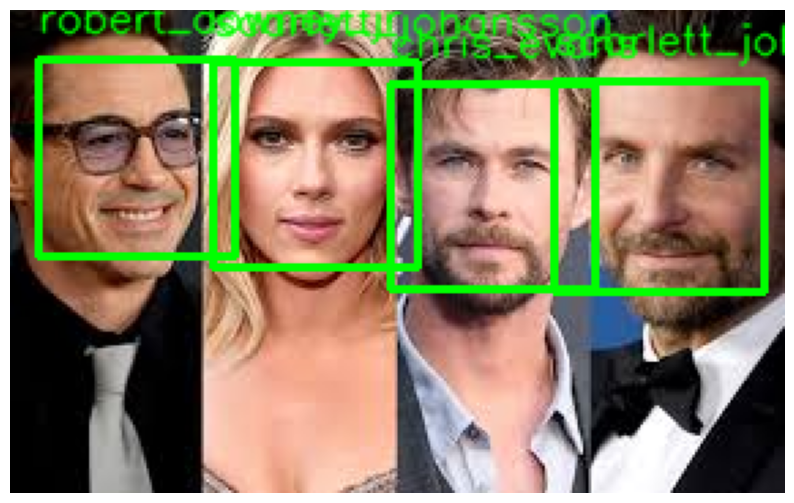

In [44]:
uploaded = files.upload()

if uploaded:
    # Get the name of the uploaded file
    uploaded_file_name = list(uploaded.keys())[0]
    print(f"Uploaded file: {uploaded_file_name}")

    # Read the uploaded image
    image_array = cv2.imread(uploaded_file_name)

    # Check if the image was loaded successfully
    if image_array is not None:
        print("Image loaded successfully.")
        # Call the recognize_faces_in_image function
        result_image = recognize_faces_in_image(image_array)

        # Check if the recognition function returned a valid image
        if result_image is not None:
            print("Face detection and recognition completed.")
            # Convert BGR to RGB for displaying with matplotlib
            result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

            # Display the result
            plt.figure(figsize=(10, 10))
            plt.imshow(result_image_rgb)
            plt.axis('off')
            plt.show()
        else:
            print("Face recognition process failed.")
    else:
        print(f"Error: Could not read image from {uploaded_file_name}")
else:
    print("No file uploaded.")
